In [1]:
import pandas as pd
import numpy as np
from nibabel import nifti1
import nibabel as nib
import nilearn.plotting as niplt
from neurosynth.base import imageutils
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Generate ROI image

In [2]:
def map_peaks_to_image(peaks, r=4, vox_dims=(2, 2, 2), dims=(91, 109, 91),
                       header=None, affine=None):
    """ Take a set of discrete foci (i.e., 2-D array of MNI coordinates)
    and generate a corresponding image, convolving each focus with a
    hard sphere of radius r. 
    
    Value is order number"""
    data = np.zeros(dims)
    for i, p in enumerate(peaks):
        valid = imageutils.get_sphere(p, r, vox_dims, dims)
        data[tuple(valid.T)] = i+1
    return nifti1.Nifti1Image(data, affine, header=header)

In [3]:
peaks = pd.read_csv('../masks/wash_u/Consensus264.csv')

In [4]:
roi_communities = peaks[['ROI', 'Community']].rename(columns={'ROI' : 'region', 'Community' : 'community'})

In [5]:
short_hand = {'Uncertain': 'UC', 'Sensory/somatomotor Hand' : 'Sens_hand', 'Sensory/somatomotor Mouth' : 'Sens_hand', 
 'Cingulo-opercular Task Control': 'CON', 'Auditory':'Auditory', 'Default mode' : 'Default', 'Memory retrieval?' :'Memory',
 'Ventral attention' : 'VAtt', 'Visual' : 'Visual', 'Fronto-parietal Task Control' : 'FPN',
       'Salience':'Salience', 'Subcortical':'Subcortical', 'Cerebellar':'Cerebellar', 'Dorsal attention':'DAtt'}

In [6]:
roi_communities['comm'] = roi_communities.community.map(short_hand)

In [7]:
import random
colors = sns.color_palette("Set3", n_colors=peaks.Community.unique().shape[0]-1)
# random.shuffle(colors)

In [8]:
community_colors = dict(zip(peaks.Community.unique()[1:], colors))

In [9]:
community_colors['Uncertain'] = (.9, .9, .9)

In [10]:
peaks['colors'] = peaks.Community.map(community_colors)

In [11]:
test_img = nib.load('../masks/FPN_hierarchical.nii.gz')

In [12]:
mni_origin = [45, 63, 36] 
vox_peaks = (peaks[['X', 'Y', 'Z']].values / 2 ) + mni_origin

In [13]:
img = map_peaks_to_image(vox_peaks, r=8, affine=test_img.get_affine())

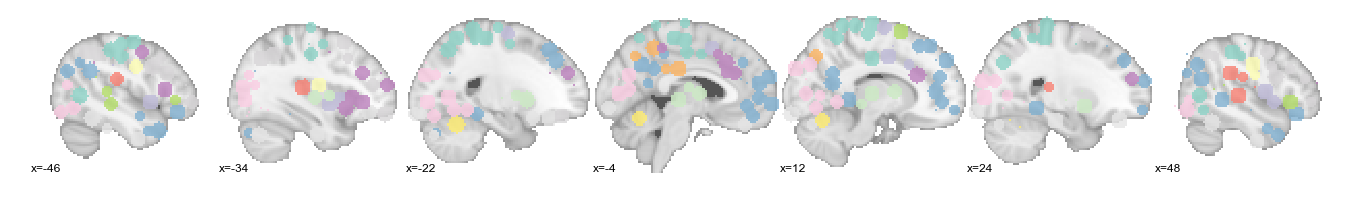

In [14]:
niplt.plot_roi(img, draw_cross=False, cmap=ListedColormap(peaks.colors), alpha=.8, display_mode='x')

In [15]:
nib.save(img, '../masks/wash_u/Power_4mm.nii.gz')

In [16]:
def find_roi(img, roi):
    from copy import deepcopy
    img = deepcopy(img)
    data = img.get_data()
    data[data != roi] = 0
    niplt.plot_roi(img)

### OvA classification

In [17]:
from base.classifiers import OnevsallClassifier

In [18]:
oclf = OnevsallClassifier.load('../results/classification/Power_Ridge_t0.05_cog_topics_60/classifier_nd.pkl')

In [19]:
from sklearn.metrics import pairwise_distances

In [20]:
fi_dist = pairwise_distances(oclf.feature_importances, metric='correlation')

In [21]:
fi_dist.shape

(264, 264)

In [22]:
known_peaks = peaks[peaks.ROI.isin(peaks[peaks.Community == 'Uncertain'].ROI) == False]
ix = known_peaks.ROI - 1

In [23]:
fi_dist_known = fi_dist[ix][:, ix]

In [24]:
known_peaks.shape

(236, 6)

In [25]:
fi_dist_known.shape

(236, 236)

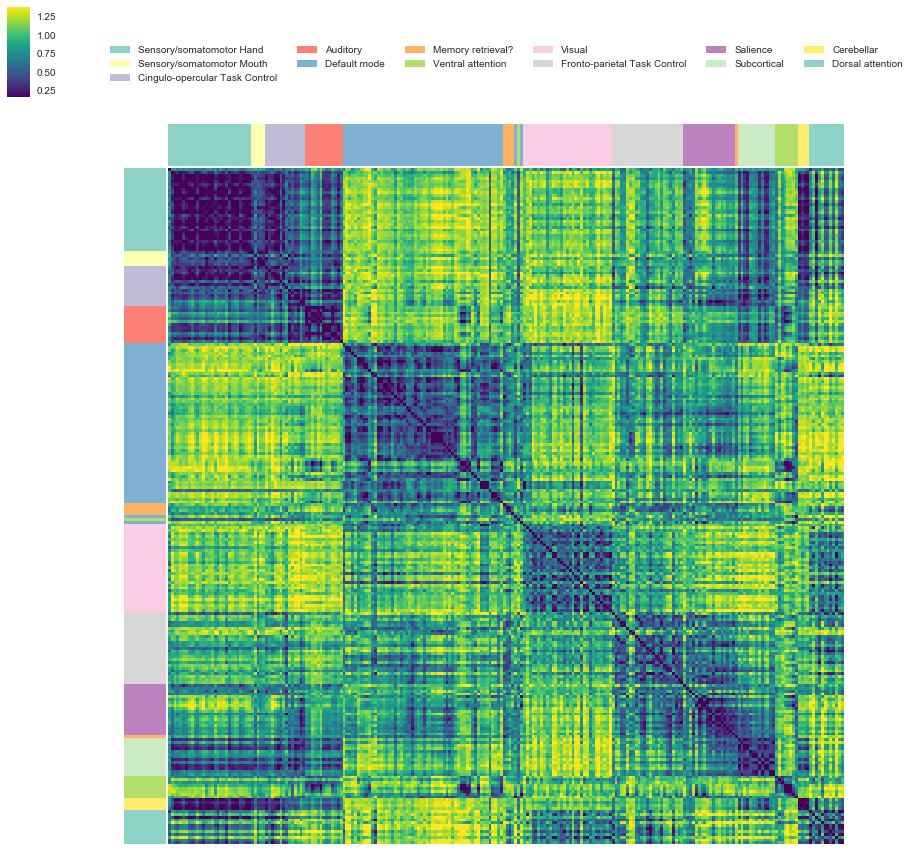

In [26]:
g = sns.clustermap(fi_dist_known, cmap=plt.get_cmap('viridis'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=list(known_peaks.colors), row_colors=list(known_peaks.colors), xticklabels=False, yticklabels=False,
                figsize=(15, 15))

for label in known_peaks.Community.unique():
    g.ax_col_dendrogram.bar(0, 0, color=community_colors[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [27]:
rs_fmri = pd.read_csv("../masks/Andy/mean_matrix_264.csv", header=None)

In [40]:
from base.classifiers import PairwiseClassifier
pairwise_clf = PairwiseClassifier.load('../results/classification/Power_pairwise/classifier_nd.pkl')


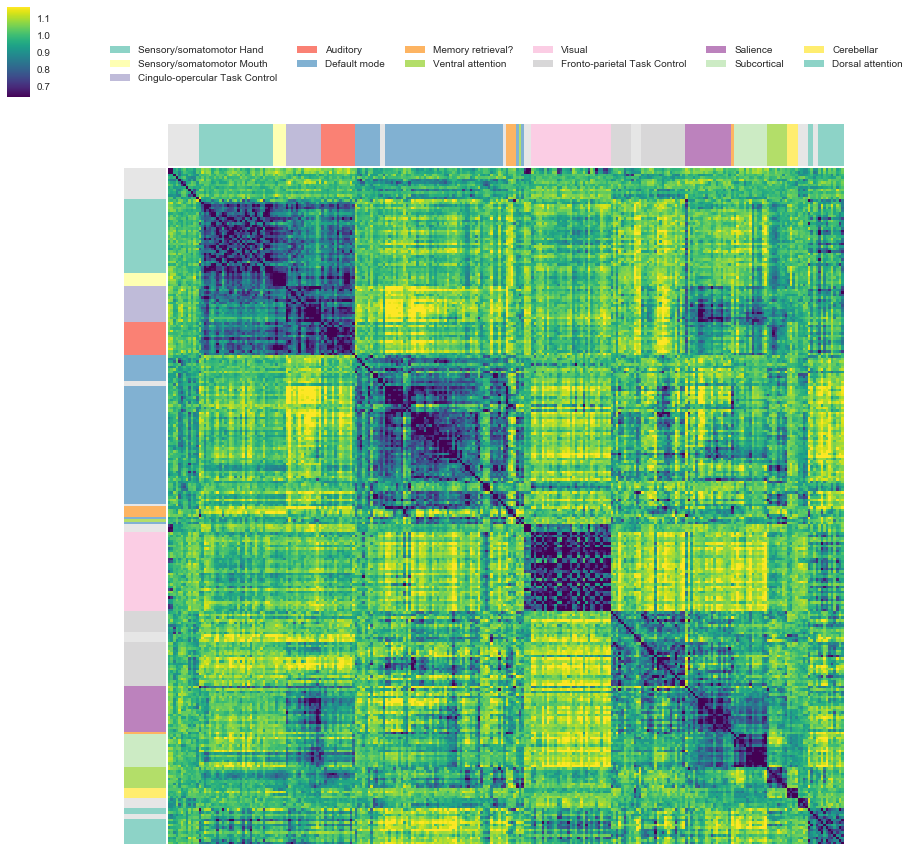

In [37]:
g = sns.clustermap(1 - rs_fmri, cmap=plt.get_cmap('viridis'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=list(peaks.colors), row_colors=list(peaks.colors), xticklabels=False, yticklabels=False,
                figsize=(15, 15))

for label in known_peaks.Community.unique():
    g.ax_col_dendrogram.bar(0, 0, color=community_colors[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [45]:
from scipy.stats import pearsonr
pearsonr(fi_dist.flatten(), rs_fmri.values.flatten())

(-0.57402475827741994, 0.0)

In [193]:
?sns.clustermap

In [44]:
from scipy.stats import pearsonr

In [45]:
pearsonr(fi_dist.flatten(), clf.class_score.flatten())

(0.53393881197758264, 0.0)

In [46]:
ova_dist_melt = pd.melt(pd.DataFrame(fi_dist).reset_index().rename(columns={'index' : 'region_a'}), 
        id_vars='region_a', var_name='region_b', value_name='corr_dist').dropna()

ova_dist_melt = pd.merge(ova_dist_melt, roi_communities, left_on='region_a', right_on='region').drop(
    'region', axis=1).rename(columns={'community' : 'community_a', 'comm' : 'comm_a'})
ova_dist_melt = pd.merge(ova_dist_melt, roi_communities, left_on='region_b', right_on='region').drop(
    'region', axis=1).rename(columns={'community' : 'community_b', 'comm' : 'comm_b'})
ova_dist_melt['within'] = ova_dist_melt.community_a == ova_dist_melt.community_b

In [47]:
ova_dist_melt['corr_dist_z'] = (ova_dist_melt.corr_dist - ova_dist_melt.corr_dist.mean()) / ova_dist_melt.corr_dist.std()

In [48]:
ova_dist_between = ova_dist_melt[ova_dist_melt.within == False]

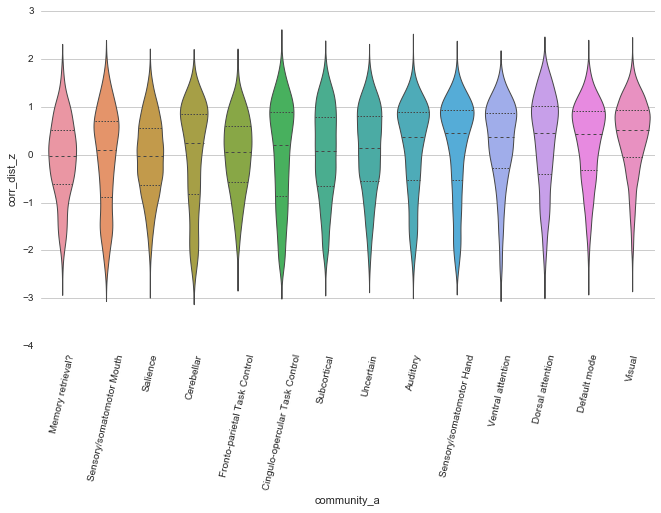

In [49]:
f, ax = plt.subplots(figsize=(11, 6))
g= sns.violinplot(y='corr_dist_z', data=ova_dist_between, x='community_a',linewidth=1, inner='quartile',
                  order=ova_dist_between.groupby('community_a').mean().sort('corr_dist').index)
sns.despine(left=True, bottom=True)
for item in g.get_xticklabels():
    item.set_rotation(77)
# ax.set(ylim=(0.45, 0.75))

In [50]:
mean_within_diff = ova_dist_melt.groupby('comm_a').apply(lambda x: x[x.within == False].corr_dist_z.mean() - x[x.within == True].corr_dist_z.mean())

In [51]:
mean_within_diff.sort()

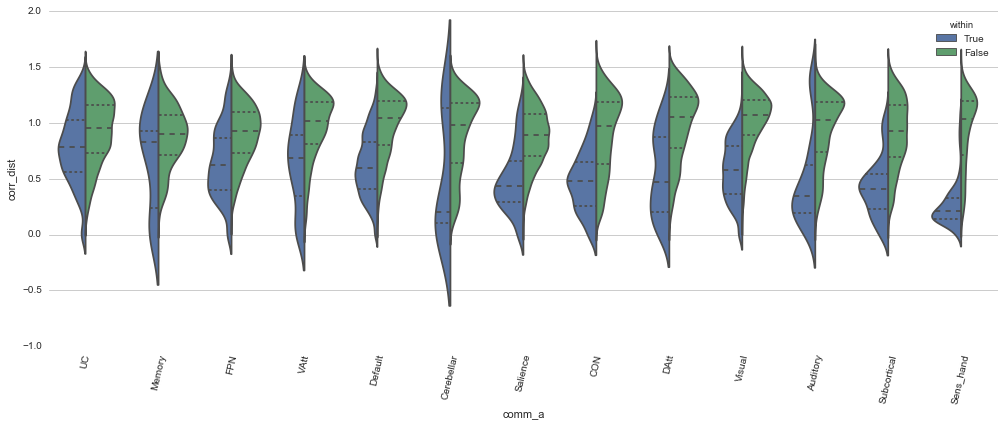

In [52]:
f, ax = plt.subplots(figsize=(17, 6))
g = sns.violinplot(x='comm_a', y='corr_dist', hue='within', split=True, data=ova_dist_melt,
                  order = mean_within_diff.index,
                  inner='quartile')
sns.despine(left=True, bottom=True)
for item in g.get_xticklabels():
    item.set_rotation(77)

In [53]:
mean_dist_communities = ova_dist_melt.groupby(['community_a', 'community_b']).mean().reset_index()

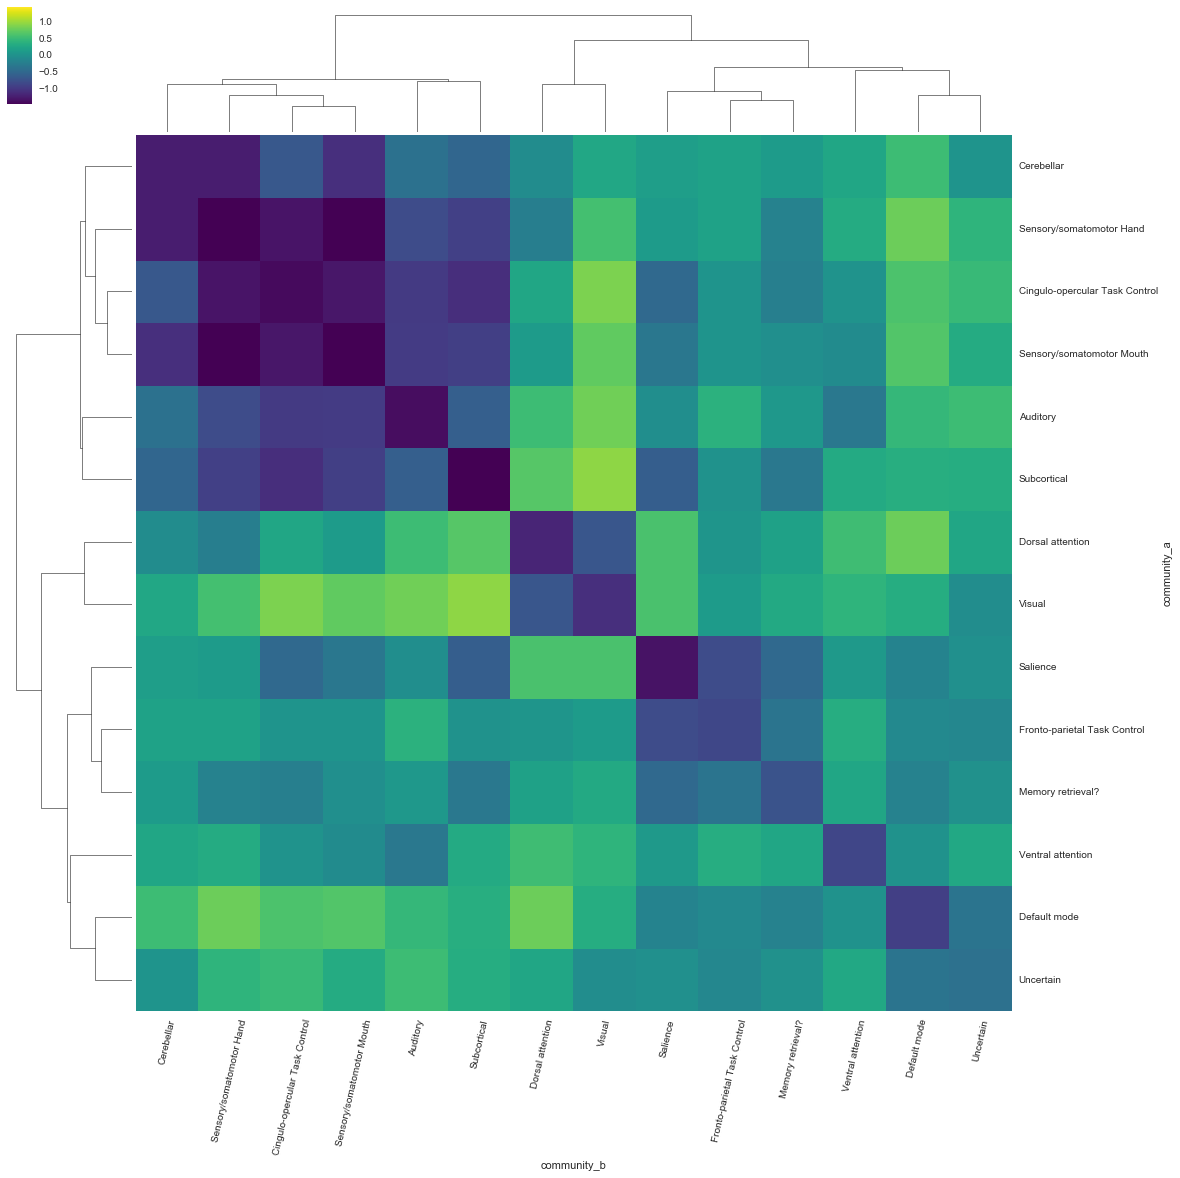

In [54]:
g = sns.clustermap(mean_dist_communities.pivot(index='community_a', columns='community_b', values='corr_dist_z'),
               cmap=plt.get_cmap('viridis'), robust=True, figsize=(18, 18))
for item in g.ax_heatmap.get_xticklabels():
    item.set_rotation(77)
    
for item in g.ax_heatmap.get_yticklabels():
    item.set_rotation(0)

### Functional specialization of networks

In [55]:
## Set up topic nicknames
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + '60' + "-july_cognitive.csv")
word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')

o_fi = pd.DataFrame(oclf.feature_importances)

# Melt feature importances, and add top_words for each feeature
o_fi['region'] = range(1, o_fi.shape[0] + 1)
o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

word_keys = pd.merge(pd.DataFrame({'topic_order' : range(0, len(clf.feature_names)), 'topic_name' : clf.feature_names}), word_keys)
word_keys.topic_order = word_keys.topic_order.astype('int')

o_fis_melt= pd.merge(pd.merge(o_fis_melt, word_keys), roi_communities)

In [70]:
def plot_clf_polar(fis, cmap=None, key='nickname', n_top=3, labels=None, mask=None, selection='top', metric='correlation', max_val=None, return_labels=False, average=False):  
    from base.plotting import plot_polar
    if mask is not None:
        fis = fis[fis.region.isin(mask)]
        
    if average is True:
        fis = fis.groupby(key).mean().reset_index()
        
    pplot = pd.pivot_table(fis, values='importance', index=[key], columns=['region'])
    
    if cmap is None:
        cmap = sns.color_palette('Set1', clf.feature_importances.shape[0])

    return plot_polar(pplot, overplot=True, palette=cmap, n_top=n_top, metric=metric, selection=selection, 
        label_size=20, labels=labels, max_val=max_val, return_labels=return_labels, alpha_level=0.35)

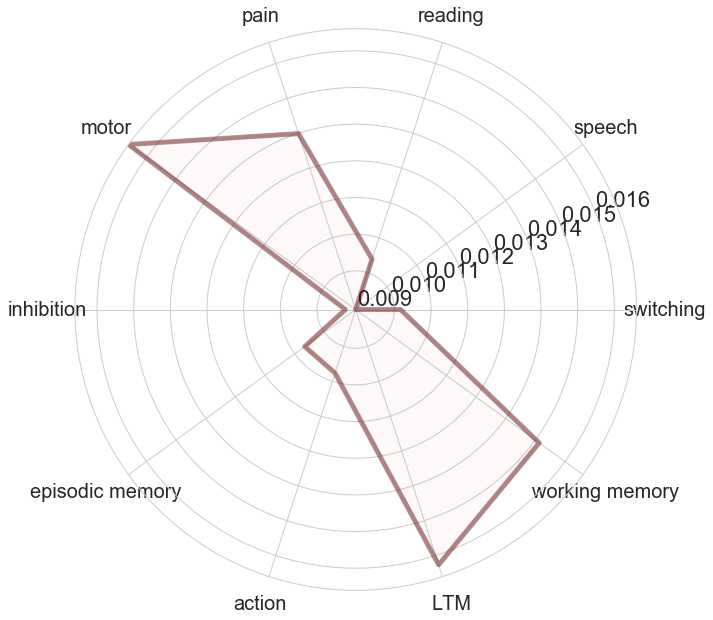

In [71]:
plot_clf_polar(o_fis_melt, n_top=10, average=True)

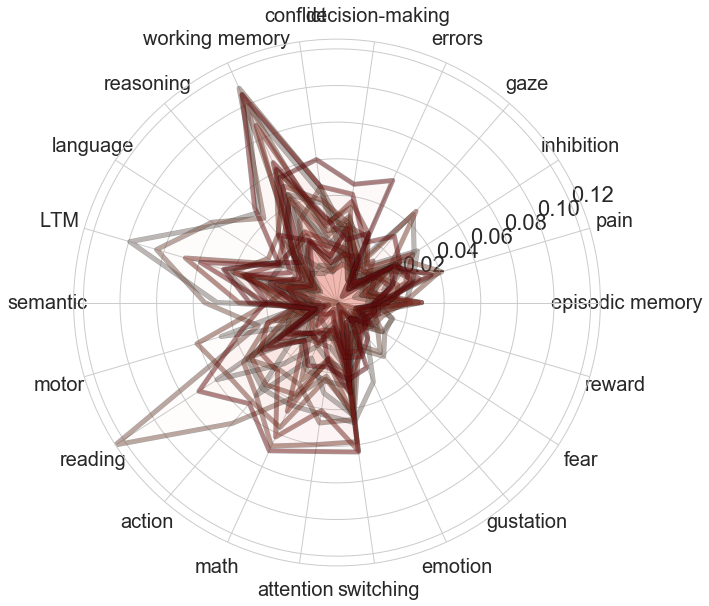

In [75]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'FPN'].region.unique(), n_top=4, cmap=sns.color_palette("Reds", 30))

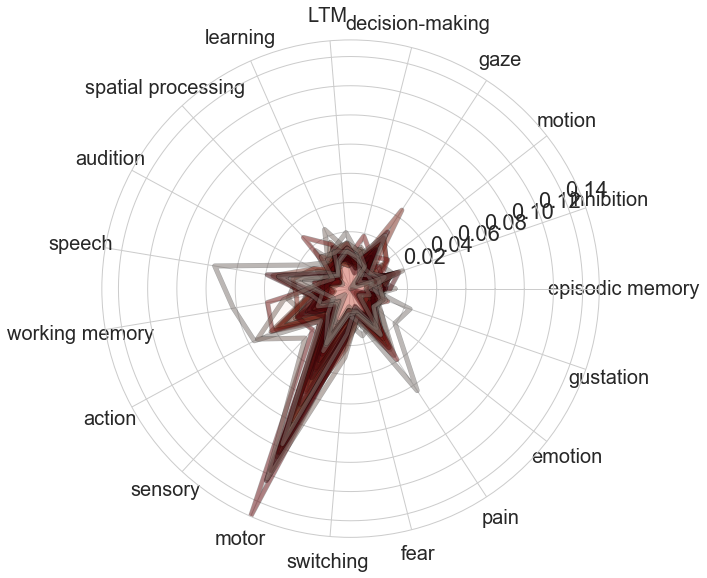

In [74]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'Sens_hand'].region.unique(), n_top=4, cmap=sns.color_palette("Reds", 30))

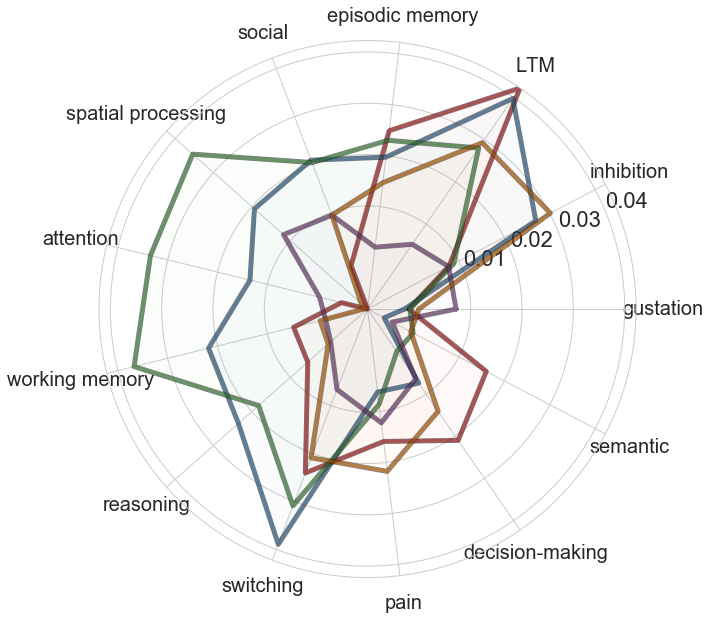

In [60]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'Memory'].region.unique(), n_top=6)

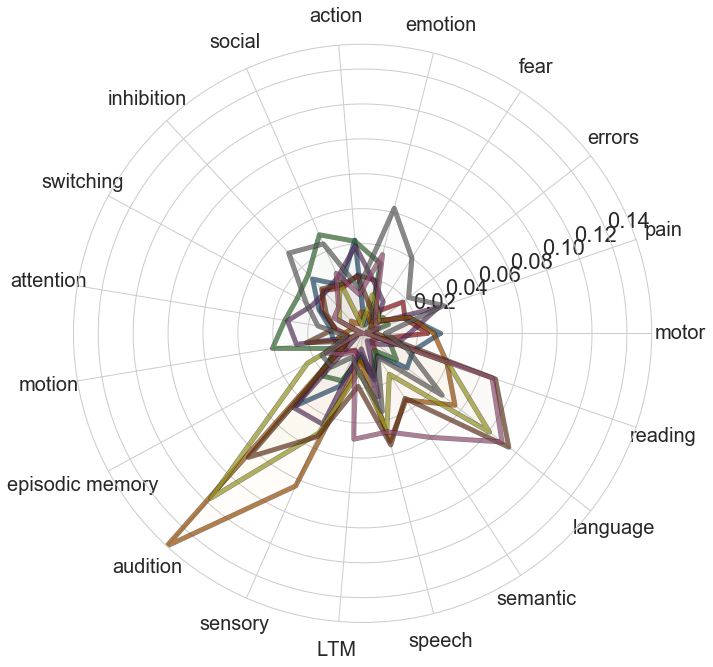

In [61]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'VAtt'].region.unique(), n_top=6)

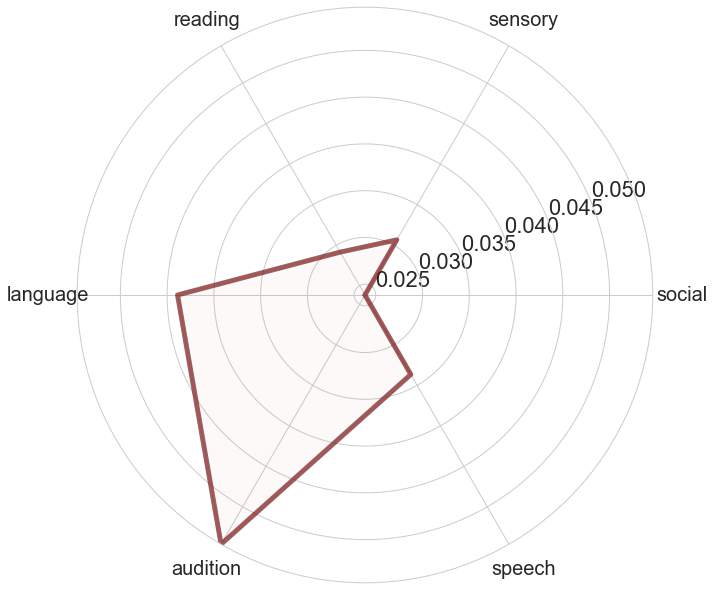

In [62]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'VAtt'].region.unique(), n_top=6, average=True)

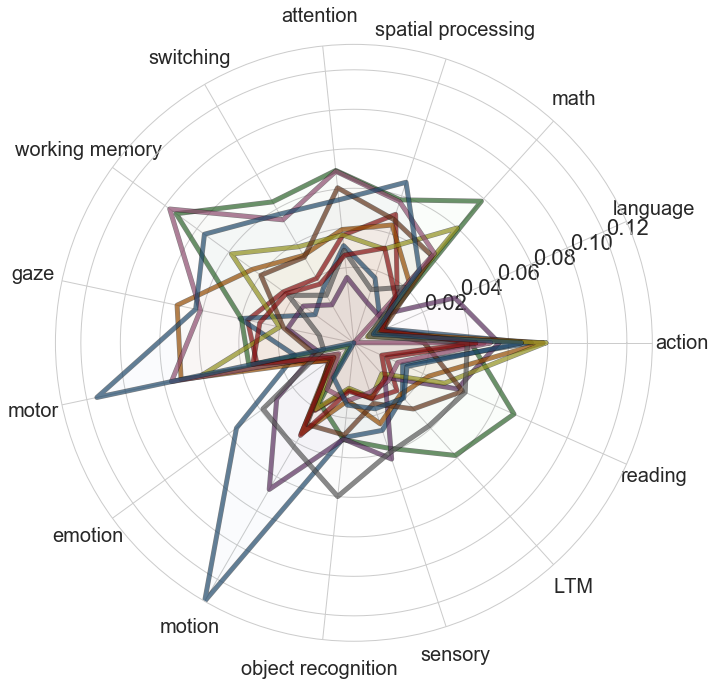

In [63]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'DAtt'].region.unique(), n_top=6)

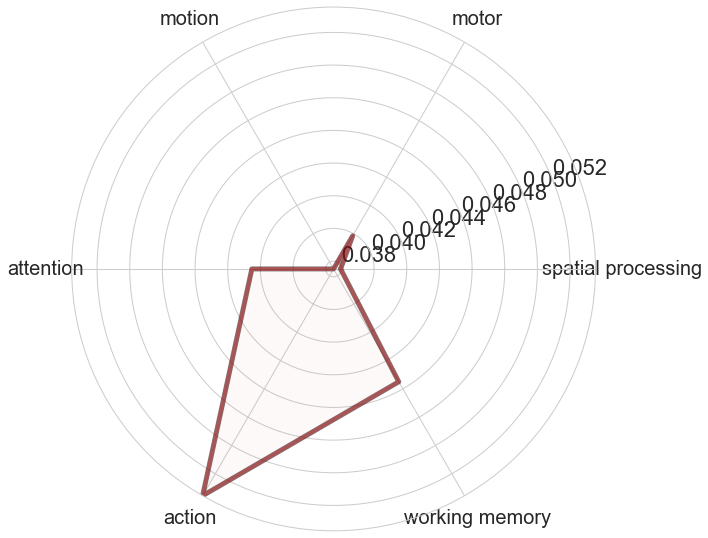

In [64]:
plot_clf_polar(o_fis_melt, mask=o_fis_melt[o_fis_melt.comm == 'DAtt'].region.unique(), n_top=6, average=True)